## Loading the dataset

In [1]:
import pandas as pd
df = pd.read_csv("../mouth_year.csv")
df.head()

,production,p_per_m2,p_max,panel_area,facade_area,total_panel_area,exploitation_ratio,air_temp_mean,air_temp_max,clearsky_ghi_mean,...,relative_humidity_max,surface_pressure_mean,surface_pressure_min,surface_pressure_max,wind_direction_100m_mean,wind_direction_100m_min,wind_direction_100m_max,wind_speed_100m_mean,wind_speed_100m_min,wind_speed_100m_max
0,7.461290,143.0,210.0,1.72,218.0,94.6,0.434,1.885252,3.612903,72.773750,...,90.400000,1017.477354,1013.751613,1021.354839,213.224691,148.193548,273.870968,5.215817,3.112903,7.035484
1,3.100000,143.0,210.0,1.72,218.0,94.6,0.434,2.395833,4.000000,72.791667,...,90.600000,1017.168750,1015.500000,1021.000000,227.041667,192.000000,283.000000,4.781250,2.600000,7.400000
2,30.171429,143.0,210.0,1.72,218.0,94.6,0.434,5.704613,11.500000,120.002232,...,87.157143,1024.363914,1021.210714,1027.460714,179.183036,127.214286,233.535714,4.203720,2.382143,6.142857
3,39.050000,143.0,210.0,1.72,218.0,94.6,0.434,6.229167,12.000000,117.760417,...,90.050000,1026.685417,1023.400000,1030.000000,191.343750,154.000000,217.000000,3.611458,1.450000,5.500000
4,26.516129,143.0,210.0,1.72,218.0,94.6,0.434,8.653686,12.870968,189.389254,...,85.245161,1020.149565,1016.722581,1023.654839,180.347464,125.225806,232.806452,6.274361,3.974194,8.567742


In [2]:
df.shape

(726, 34)

## Preoaring the (x,y) pairs

### Scaling the data

In [3]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df.values)

### Creating windows

In [4]:
production_column = 'production'

def get_target_column_index(df, target_column):
    for i, column in enumerate(df.columns):
        if column == target_column:
            return i

    return -1

In [5]:
import numpy as np

def get_windows(data, window_size=10):
    x = []
    y = []

    for i in range(window_size, len(data)):
        x.append(data[i-window_size:i])
        y.append(data[i][get_target_column_index(df, production_column)])

    return np.array(x), np.array(y)

In [6]:
window_size = 2*12  # 2*1h window
x, y = get_windows(data_scaled, window_size=window_size)

x.shape, y.shape

((702, 24, 34), (702,))

### Splitting the data

In [7]:
train_split_index = int(0.8 * len(df))
test_split_index = int(0.9 * len(df))

x_train, y_train = x[:train_split_index], y[:train_split_index]
x_test, y_test = x[train_split_index:test_split_index], y[train_split_index:test_split_index]
x_val, y_val = x[test_split_index:], y[test_split_index:]

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((580, 24, 34), (580,), (73, 24, 34), (73,), (49, 24, 34), (49,))

### Plotting the splits

In [8]:
import matplotlib.pyplot as plt


def plot_time_series(timesteps, values, label, format='-^', start=0, end=None):
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("date")
    plt.ylabel("production")

    plt.legend(fontsize=14)
    plt.grid(True)

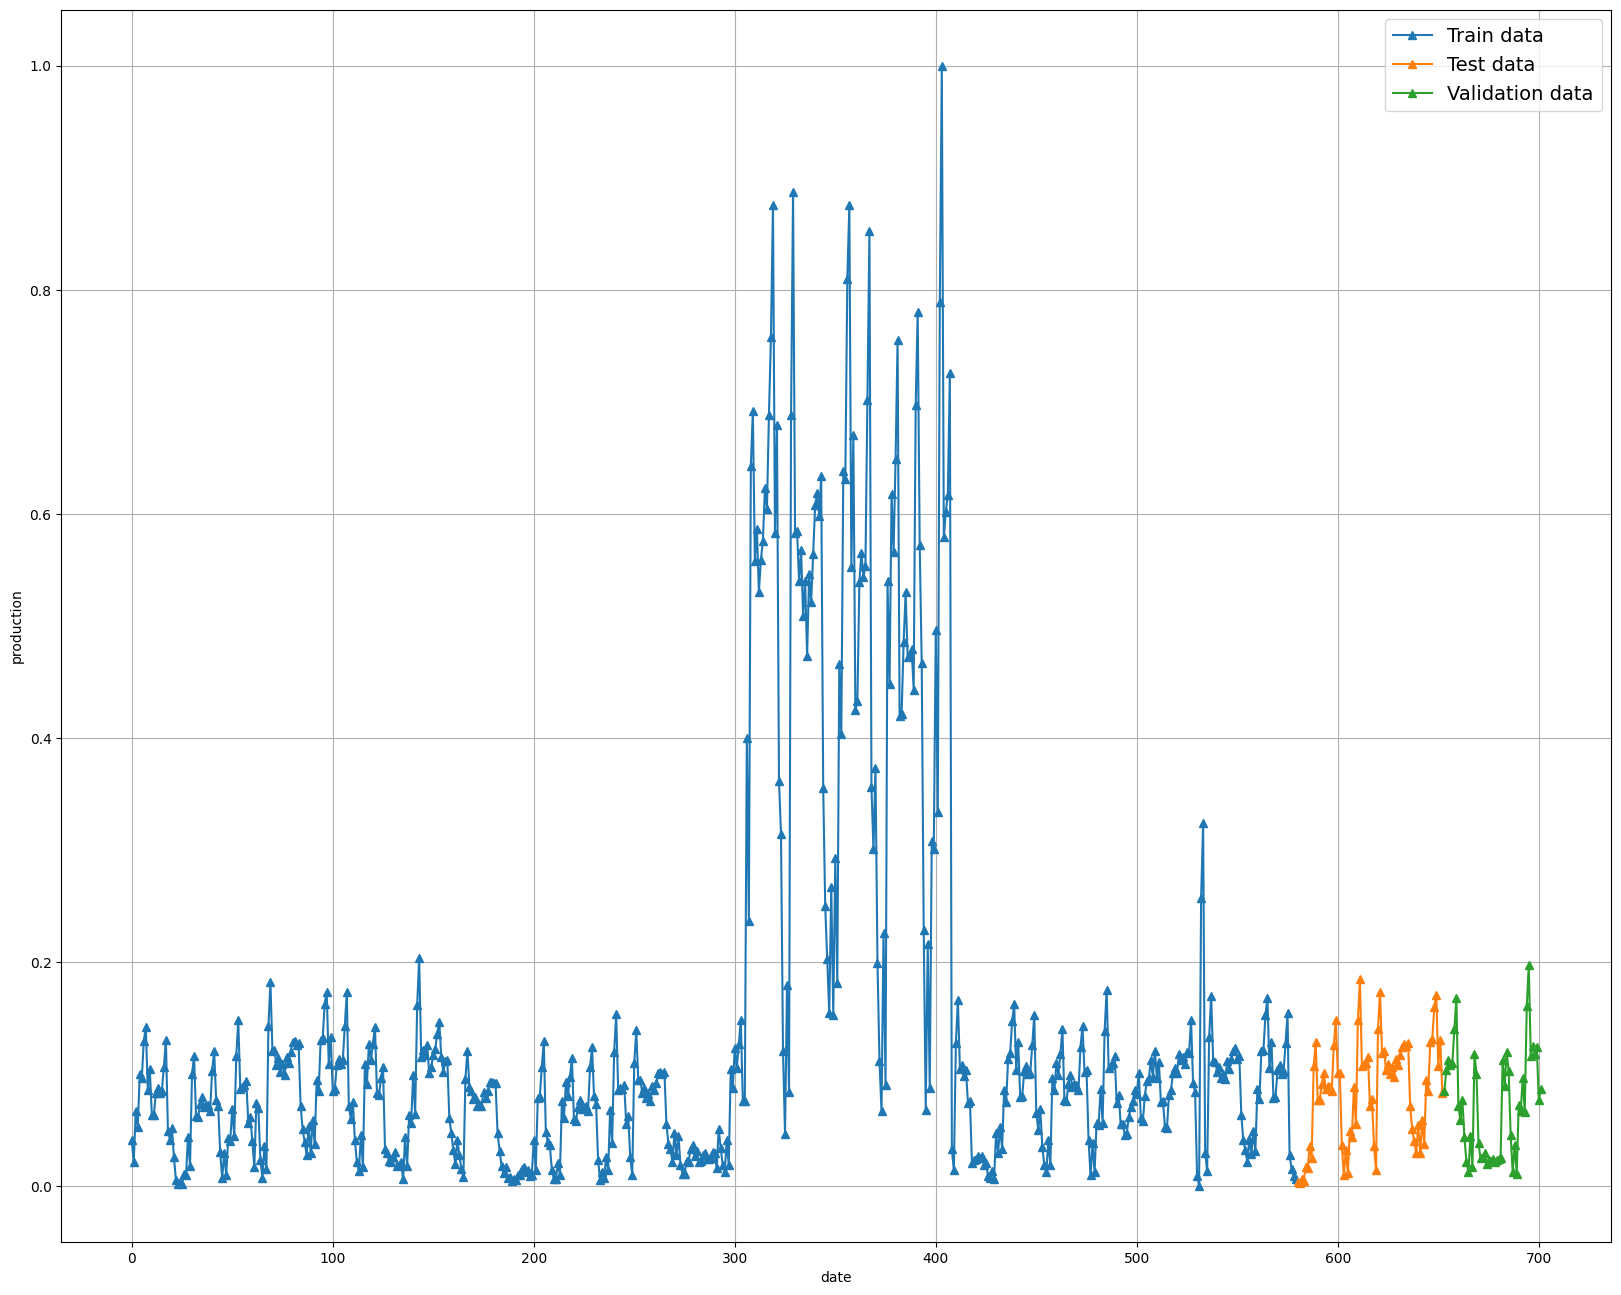

In [9]:
plt.figure(figsize=(20, 16))

timesteps = range(len(x_train))
plot_time_series(timesteps=timesteps, values=y_train, label="Train data")

timesteps = range(len(x_train), len(x_train) + len(x_test))
plot_time_series(timesteps=timesteps, values=y_test, label="Test data")

timesteps = range(len(x_train) + len(x_test),
                  len(x_train) + len(x_test) + len(x_val))
plot_time_series(timesteps=timesteps, values=y_val, label="Validation data")

### Preparing the performances metrics

In [10]:
import tensorflow as tf
from sklearn.metrics import r2_score

In [11]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return {
        'mse': mse,
        'r2': r2,
        'mae': mae,
        'mape': mape,
    }

In [12]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae_metric = tf.keras.metrics.MeanAbsoluteError()
    mse_metric = tf.keras.metrics.MeanSquaredError()

    mae_metric.update_state(y_true, y_pred)
    mse_metric.update_state(y_true, y_pred)

    mae = mae_metric.result().numpy()
    mse = mse_metric.result().numpy()
    r2 = r2_score(y_true.numpy(), y_pred.numpy())  # Assure-toi que y_true et y_pred sont des numpy arrays

    return {
        "mae": mae,
        "mse": mse,
        "r2": r2
    }

## Modeling

In [13]:
import os
import tensorflow as tf

from keras.layers import Dense, Dropout, LSTM, Flatten, ConvLSTM1D, MaxPool1D, GlobalMaxPool1D, Conv1D, Conv2D
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

### Plotting the loss

In [14]:
def plot_loss(history):
    plt.figure(figsize=(20, 8))

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

### Creating callbacks

In [15]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)


def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              verbose=0,
                                              save_best_only=True)

### Utils function

In [16]:
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

## ConvLSTM

#### Preparing the model

In [17]:
x_train_conv_lstm = np.expand_dims(x_train, axis=2)
x_val_conv_lstm = np.expand_dims(x_val, axis=2)
x_test_conv_lstm = np.expand_dims(x_test, axis=2)

print(f"{x_train.shape} -> {x_train_conv_lstm.shape}")

(580, 24, 34) -> (580, 24, 1, 34)


In [18]:
tf.random.set_seed(42)

input_shape = (x_train_conv_lstm.shape[1:])
conv_lstm_model = tf.keras.Sequential([
    ConvLSTM1D(filters=96, kernel_size=(1,), activation='tanh',
               return_sequences=True, input_shape=input_shape),
    ConvLSTM1D(filters=128, kernel_size=(1,),
               activation='relu', return_sequences=False),
    Flatten(),
    Dense(units=64, activation='relu'),
    Dense(1, activation="linear")
], name="model_conv_lstm.keras")

conv_lstm_model.compile(loss="mae",
                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.000276833969681907))

conv_lstm_model.summary()

C:\Users\yhoci\blocml\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "model_conv_lstm.keras"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm1d (ConvLSTM1D)             │ (None, 24, 1, 96)           │          50,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm1d_1 (ConvLSTM1D)           │ (None, 1, 128)              │         115,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 173,825 (679.00 KB)

 Trainable params: 173,825 (679.00 KB)

 Non-trainable params: 0 (0.00 B)

#### Training the model convlstm

In [19]:
import os
import time
import logging
from codecarbon import EmissionsTracker


os.makedirs('emissions', exist_ok=True)

tracker_conv_lstm = EmissionsTracker(
    project_name="PEWH",
    co2_signal_api_token="9RkoBO6iipmoq",
    log_level=logging.INFO,
    output_file="emissions_conv_lstm.csv",
    output_dir='./emissions/',
    save_to_file=True,
    measure_power_secs=10
)

[codecarbon INFO @ 21:12:14] [setup] RAM Tracking...
[codecarbon INFO @ 21:12:14] [setup] CPU Tracking...
[codecarbon WARNING @ 21:12:14] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon WARNING @ 21:12:16] We saw that you have a AMD Ryzen 7 7840HS w/ Radeon 780M Graphics but we don't know it. Please contact us.
[codecarbon INFO @ 21:12:16] CPU Model on constant consumption mode: AMD Ryzen 7 7840HS w/ Radeon 780M Graphics
[codecarbon INFO @ 21:12:16] [setup] GPU Tracking...
[codecarbon INFO @ 21:12:16] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 21:12:16] >>> Tracker's metadata:
[codecarbon INFO @ 21:12:16]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:12:16]   Python version: 3.12.3
[codecarbon INFO @ 21:12:16]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 21:12:16]   Available RAM : 15.288 GB
[codecarbon INFO @ 21:12:16]   CPU count: 16
[codecarbon INFO @ 21:

In [20]:
def start_training_conv_lstm():
    start_time = time.time()
    conv_lstm_history = conv_lstm_model.fit(x=x_train_conv_lstm,
                                            y=y_train,
                                            epochs=300,
                                            verbose=1,
                                            batch_size=512,
                                            validation_data=(
                                                x_val_conv_lstm, y_val),
                                            callbacks=[create_model_checkpoint(model_name=conv_lstm_model.name)])
    training_duration = time.time() - start_time

    return conv_lstm_history, training_duration

In [21]:
tracker_conv_lstm.start()
try:
    history_conv_lstm, training_duration_conv_lstm = start_training_conv_lstm()
finally:
    tracker_conv_lstm.stop()

Epoch 1/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 572ms/step - loss: 0.1181 - val_loss: 0.0390
Epoch 2/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0942 - val_loss: 0.0455
Epoch 3/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0925 - val_loss: 0.0397
Epoch 4/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0841 - val_loss: 0.0408
Epoch 5/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0802 - val_loss: 0.0408
Epoch 6/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0760 - val_loss: 0.0400
Epoch 7/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0710 - val_loss: 0.0417
Epoch 8/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0689 - val_loss: 0.0403
Epoch 9/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0648 - val_loss: 0.0412
Epoch 10/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0650 - val_loss: 0.0405
Epoch 11/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0630 - val_loss: 0.0419
Epoch 12/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0649

[codecarbon INFO @ 21:12:26] Energy consumed for RAM : 0.000016 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 21:12:26] Energy consumed for all CPUs : 0.000119 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:12:26] Energy consumed for all GPUs : 0.000014 kWh. Total GPU Power : 4.912056867219675 W
[codecarbon INFO @ 21:12:26] 0.000148 kWh of electricity used since the beginning.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0561 - val_loss: 0.0371
Epoch 27/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0560 - val_loss: 0.0374
Epoch 28/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0551 - val_loss: 0.0369
Epoch 29/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0547 - val_loss: 0.0372
Epoch 30/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0541 - val_loss: 0.0368
Epoch 31/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0547 - val_loss: 0.0367
Epoch 32/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0532 - val_loss: 0.0362
Epoch 33/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.0535 - val_loss: 0.0359
Epoch 34/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0522 - val_loss: 0.0355
Epoch 35/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0515 - val_loss: 0.0354
Epoch 36/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0516 - val_loss: 0.0366
Epoch 37/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0503 - 

[codecarbon INFO @ 21:12:36] Energy consumed for RAM : 0.000032 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 21:12:36] Energy consumed for all CPUs : 0.000237 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:12:36] Energy consumed for all GPUs : 0.000022 kWh. Total GPU Power : 3.130316385650839 W
[codecarbon INFO @ 21:12:36] 0.000291 kWh of electricity used since the beginning.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0398 - val_loss: 0.0347
Epoch 71/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0403 - val_loss: 0.0359
Epoch 72/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0398 - val_loss: 0.0348
Epoch 73/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0398 - val_loss: 0.0333
Epoch 74/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0403 - val_loss: 0.0333
Epoch 75/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0396 - val_loss: 0.0338
Epoch 76/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0395 - val_loss: 0.0338
Epoch 77/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0392 - val_loss: 0.0334
Epoch 78/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0399 - val_loss: 0.0341
Epoch 79/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0411 - val_loss: 0.0346
Epoch 80/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0403 - val_loss: 0.0349
Epoch 81/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0411 - 

[codecarbon INFO @ 21:12:46] Energy consumed for RAM : 0.000048 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 21:12:46] Energy consumed for all CPUs : 0.000355 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:12:46] Energy consumed for all GPUs : 0.000037 kWh. Total GPU Power : 5.1777720864829755 W
[codecarbon INFO @ 21:12:46] 0.000439 kWh of electricity used since the beginning.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0383 - val_loss: 0.0329
Epoch 116/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0380 - val_loss: 0.0333
Epoch 117/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0376 - val_loss: 0.0338
Epoch 118/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0379 - val_loss: 0.0332
Epoch 119/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0387 - val_loss: 0.0337
Epoch 120/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0382 - val_loss: 0.0321
Epoch 121/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0378 - val_loss: 0.0325
Epoch 122/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0382 - val_loss: 0.0338
Epoch 123/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0377 - val_loss: 0.0332
Epoch 124/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0386 - val_loss: 0.0325
Epoch 125/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0371 - val_loss: 0.0336
Epoch 126/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.038

[codecarbon INFO @ 21:12:56] Energy consumed for RAM : 0.000064 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 21:12:56] Energy consumed for all CPUs : 0.000473 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:12:56] Energy consumed for all GPUs : 0.000048 kWh. Total GPU Power : 3.8718261019920766 W
[codecarbon INFO @ 21:12:56] 0.000584 kWh of electricity used since the beginning.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0368 - val_loss: 0.0320
Epoch 162/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0375 - val_loss: 0.0327
Epoch 163/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0366 - val_loss: 0.0316
Epoch 164/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0366 - val_loss: 0.0300
Epoch 165/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0365 - val_loss: 0.0306
Epoch 166/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0366 - val_loss: 0.0322
Epoch 167/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0360 - val_loss: 0.0326
Epoch 168/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0363 - val_loss: 0.0317
Epoch 169/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0365 - val_loss: 0.0308
Epoch 170/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0363 - val_loss: 0.0311
Epoch 171/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0358 - val_loss: 0.0313
Epoch 172/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.03

[codecarbon INFO @ 21:13:06] Energy consumed for RAM : 0.000080 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 21:13:06] Energy consumed for all CPUs : 0.000591 kWh. Total CPU Power : 42.5 W


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0363

[codecarbon INFO @ 21:13:06] Energy consumed for all GPUs : 0.000055 kWh. Total GPU Power : 2.5989566332505194 W
[codecarbon INFO @ 21:13:06] 0.000726 kWh of electricity used since the beginning.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0356 - val_loss: 0.0312
Epoch 208/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0365 - val_loss: 0.0333
Epoch 209/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0361 - val_loss: 0.0323
Epoch 210/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0369 - val_loss: 0.0303
Epoch 211/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0349 - val_loss: 0.0300
Epoch 212/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0356 - val_loss: 0.0314
Epoch 213/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0354 - val_loss: 0.0319
Epoch 214/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0366 - val_loss: 0.0314
Epoch 215/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0357 - val_loss: 0.0302
Epoch 216/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0356 - val_loss: 0.0311
Epoch 217/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0357 - val_loss: 0.0335
Epoch 218/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.035

[codecarbon INFO @ 21:13:16] Energy consumed for RAM : 0.000095 kWh. RAM Power : 5.732982158660889 W


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0363

[codecarbon INFO @ 21:13:16] Energy consumed for all CPUs : 0.000709 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:13:16] Energy consumed for all GPUs : 0.000072 kWh. Total GPU Power : 6.221008836144967 W
[codecarbon INFO @ 21:13:16] 0.000877 kWh of electricity used since the beginning.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0353 - val_loss: 0.0304
Epoch 255/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0341 - val_loss: 0.0314
Epoch 256/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0349 - val_loss: 0.0315
Epoch 257/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.0342 - val_loss: 0.0312
Epoch 258/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0350 - val_loss: 0.0306
Epoch 259/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0340 - val_loss: 0.0307
Epoch 260/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0343 - val_loss: 0.0309
Epoch 261/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0344 - val_loss: 0.0317
Epoch 262/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0343 - val_loss: 0.0308
Epoch 263/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0341 - val_loss: 0.0300
Epoch 264/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0339 - val_loss: 0.0310
Epoch 265/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0

[codecarbon INFO @ 21:13:26] Energy consumed for RAM : 0.000111 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 21:13:26] Energy consumed for all CPUs : 0.000827 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:13:26] Energy consumed for all GPUs : 0.000088 kWh. Total GPU Power : 5.694287506765724 W
[codecarbon INFO @ 21:13:26] 0.001026 kWh of electricity used since the beginning.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0338 - val_loss: 0.0305
Epoch 300/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0337 - val_loss: 0.0301


[codecarbon INFO @ 21:13:27] Energy consumed for RAM : 0.000112 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 21:13:27] Energy consumed for all CPUs : 0.000830 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:13:27] Energy consumed for all GPUs : 0.000099 kWh. Total GPU Power : 159.53691614388245 W
[codecarbon INFO @ 21:13:27] 0.001041 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:13:27] 0.000266 g.CO2eq/s mean an estimation of 8.3989434331508 kg.CO2eq/year


#### Ploting the loss

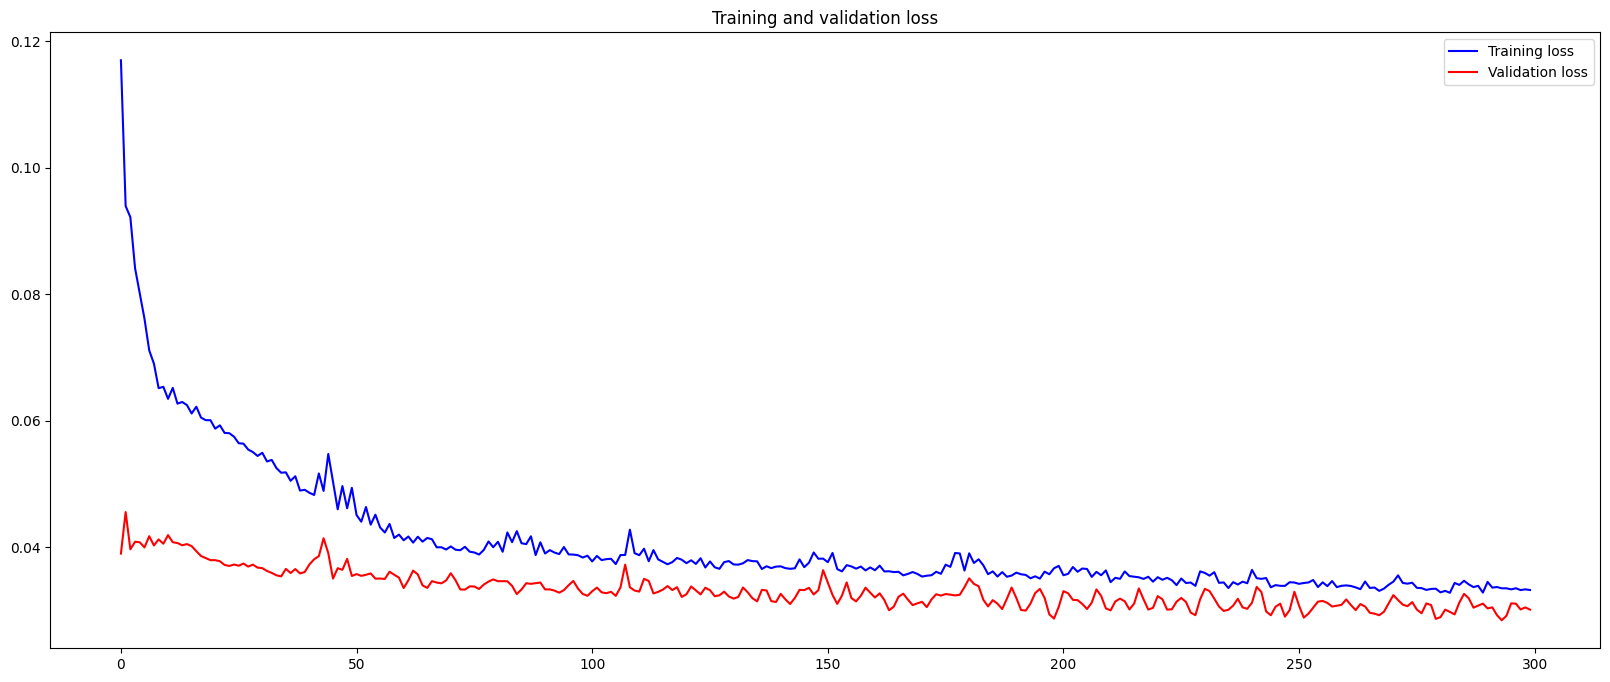

In [22]:
plot_loss(history_conv_lstm)

In [23]:
conv_lstm_model = tf.keras.models.load_model(
    "model_experiments/model_conv_lstm.keras")

model_preds = make_preds(conv_lstm_model, x_test_conv_lstm)
model_results = evaluate_preds(y_true=tf.squeeze(y_test),
                               y_pred=model_preds)

model_results

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


{'mae': np.float32(0.022450043),
 'mse': np.float32(0.00087032386),
 'r2': 0.582429826259613}

#### Plot predictions

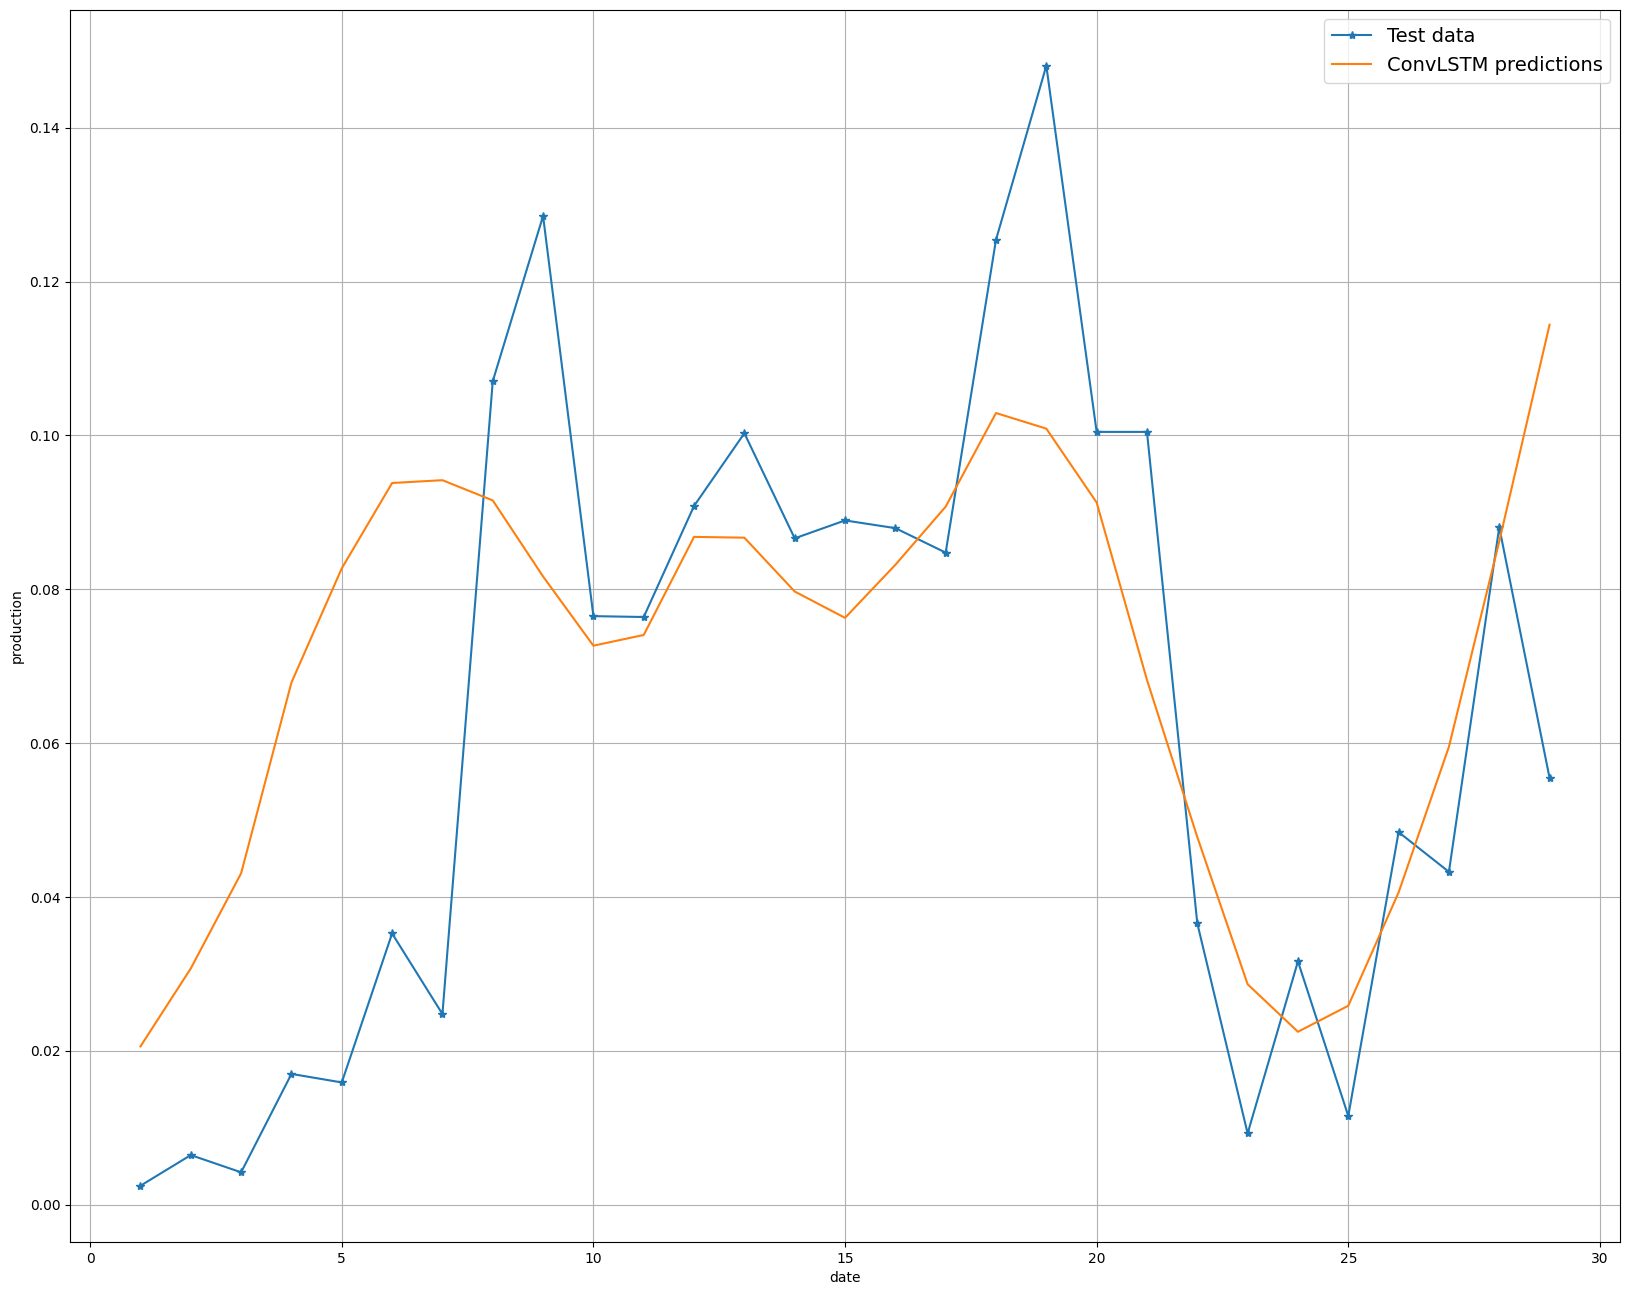

In [24]:
import numpy as np

start_offset = 1
end_offset = 30
plt.figure(figsize=(20, 16))


plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=y_test,
    start=start_offset,
    end=end_offset,
    format='-*',
    label="Test data"
)

plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=model_preds,
    start=start_offset,
    end=end_offset,
    format="-",
    label="ConvLSTM predictions"
)